<a href="https://colab.research.google.com/github/YunCheol07/DataAnalysisProject/blob/main/%EB%8D%B0%EC%9D%B4%ED%84%B0_%EB%B6%84%EC%84%9D_%EB%AF%B8%EB%8B%88_%ED%94%84%EB%A1%9C%EC%A0%9D%ED%8A%B8_%EB%AA%A8%EB%8D%B8(%EB%A7%89%ED%95%9C%EA%B1%B0)_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install koreanize-matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 57.5 MB/s eta 0:00:00


In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 7.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import optuna
from sklearn.model_selection import StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

df = pd.read_csv('train.csv')


# 기본 확인

In [ ]:
# 기본 확인
print(df.shape)



(8349, 3078)


In [ ]:
print(df.head(5))

                  SMILES  ecfp_0  ecfp_1  ecfp_2  ecfp_3  ecfp_4  ecfp_5  \
0              Nc1ccncc1       0       0       0       0       0       0   
1    Cc1cc(n[nH]1)C(=O)O       0       0       0       0       0       0   
2         NCCCS(=O)(=O)O       0       0       0       0       0       0   
3  OC(=O)c1cc2occc2[nH]1       0       0       0       0       0       0   
4   CN1CCC[C@H]1c2cccnc2       0       0       0       0       1       0   

   ecfp_6  ecfp_7  ecfp_8  ...  ptfp_1019  ptfp_1020  ptfp_1021  ptfp_1022  \
0       0       0       0  ...          0          0          0          1   
1       0       0       0  ...          0          0          0          1   
2       0       0       0  ...          0          0          0          1   
3       0       0       0  ...          0          0          0          1   
4       0       0       0  ...          0          0          0          1   

   ptfp_1023    MolWt    clogp  sa_score       qed  label  
0          0  

In [ ]:
df.describe()

,ecfp_0,ecfp_1,ecfp_2,ecfp_3,ecfp_4,ecfp_5,ecfp_6,ecfp_7,ecfp_8,ecfp_9,...,ptfp_1019,ptfp_1020,ptfp_1021,ptfp_1022,ptfp_1023,MolWt,clogp,sa_score,qed,label
count,8349.000000,8349.000000,8349.000000,8349.000000,8349.000000,8349.000000,8349.000000,8349.000000,8349.000000,8349.000000,...,8349.000000,8349.000000,8349.000000,8349.0,8349.000000,8349.000000,8349.000000,8349.000000,8349.000000,8349.000000
mean,0.014253,0.263744,0.056893,0.087316,0.203617,0.038807,0.028387,0.015810,0.092227,0.031141,...,0.213918,0.005390,0.575877,1.0,0.058211,443.248753,3.794829,3.187613,0.559151,0.544017
std,0.118540,0.440689,0.231652,0.282314,0.402712,0.193146,0.166085,0.124748,0.289363,0.173710,...,0.410094,0.073222,0.494239,0.0,0.234155,88.876374,1.379045,0.727768,0.185664,0.498089
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.0,0.000000,94.117000,-4.048930,1.282432,0.024365,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.0,0.000000,383.879000,2.874500,2.663425,0.425440,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,1.0,0.000000,441.522000,3.735100,3.093155,0.556410,1.000000
75%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,1.0,0.000000,495.639000,4.652500,3.593547,0.700506,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.0,1.000000,1242.488000,9.429480,7.309297,0.947494,1.000000


In [ ]:
# 데이터 정
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8349 entries, 0 to 8348
Columns: 3078 entries, SMILES to label
dtypes: float64(4), int64(3073), object(1)
memory usage: 196.1+ MB
None


In [ ]:
# 샘플 확인
df.sample(3, random_state=0)

,SMILES,ecfp_0,ecfp_1,ecfp_2,ecfp_3,ecfp_4,ecfp_5,ecfp_6,ecfp_7,ecfp_8,...,ptfp_1019,ptfp_1020,ptfp_1021,ptfp_1022,ptfp_1023,MolWt,clogp,sa_score,qed,label
4703,CO[C@@H]1COCC[C@@H]1N[C@@H]2CC[C@](C2)(C(C)C)C...,0,1,0,0,0,0,0,0,0,...,0,0,1,1,0,469.626,2.7003,4.983371,0.693791,1
422,C[C@@H]1CCCN1CCc2ccc3nc(ccc3c2)c4ccn[nH]4,0,1,0,0,1,0,0,0,0,...,1,0,0,1,0,306.413,3.6517,2.853229,0.799950,1
6450,CCN1N=C(OC1=O)[C@@]2(N[C@H](Cc3c2[nH]c4ccccc34...,0,1,0,0,0,0,1,0,0,...,1,0,1,1,0,539.575,3.6570,4.438038,0.293993,0


In [ ]:
# 데이터 불균형 확인
df['label'].value_counts(normalize=True)

,proportion
label,
1,0.544017
0,0.455983


In [ ]:
# 데이터 결측치 확인
df.isna().sum().sort_values(ascending=False).head(20)

,0
label,0
SMILES,0
ecfp_0,0
ecfp_1,0
ecfp_2,0
ecfp_3,0
ptfp_1012,0
ptfp_1011,0
ptfp_1010,0
ptfp_1009,0


# 전처리 코드

In [ ]:
# 1) 정확한 컬럼명 확인 (반드시 실행)
print("전체 컬럼 수:", len(df.columns))
print("\n처음 10개 컬럼:", df.columns[:10].tolist())
print("마지막 10개 컬럼:", df.columns[-10:].tolist())

# 2) 컬럼 그룹 분리
fp_cols = [col for col in df.columns if col.startswith(('ecfp_', 'fcfp_', 'ptfp_'))]

# 대소문자 정확히 맞춰서 지정 (아래 중 하나 선택)
# 방법 1: 직접 지정 (이미지 기준)
desc_cols = ['MolWt', 'clogp', 'sa_score', 'qed']  # clogp는 소문자!

# 방법 2: 자동 탐색 (안전)
# desc_cols = [col for col in df.columns
#              if col.lower() in ['molwt', 'clogp', 'sa_score', 'qed']]

id_col = 'SMILES'
label_col = 'label'

print(f"\nFingerprint 컬럼: {len(fp_cols)}개")
print(f"물성 컬럼: {desc_cols}")

# 3) 컬럼 존재 확인 (안전 체크)
missing_cols = [col for col in desc_cols if col not in df.columns]
if missing_cols:
    print(f"\n경고: 다음 컬럼이 없습니다 - {missing_cols}")
    print("실제 유사 컬럼:", [col for col in df.columns if any(m.lower() in col.lower() for m in missing_cols)])
    raise ValueError("컬럼명을 확인하세요")

# 4) X, y 분리
X = df.drop(columns=[label_col])
y = df[label_col].astype(int)

# 5) 전처리 파이프라인
fp_transformer = SimpleImputer(strategy='constant', fill_value=0)

desc_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())  # 트리만 쓸 경우 주석 처리
])

preprocessor = ColumnTransformer(
    transformers=[
        ('fp', fp_transformer, fp_cols),
        ('desc', desc_transformer, desc_cols)
    ],
    remainder='drop'
)

# 6) 교차검증
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (tr_idx, va_idx) in enumerate(skf.split(X, y), 1):
    X_tr, X_va = X.iloc[tr_idx], X.iloc[va_idx]
    y_tr, y_va = y.iloc[tr_idx], y.iloc[va_idx]

    Xt_tr = preprocessor.fit_transform(X_tr)
    Xt_va = preprocessor.transform(X_va)

    print(f"\n[Fold {fold}]")
    print(f"  학습: {Xt_tr.shape}, 검증: {Xt_va.shape}")
    print(f"  라벨 분포(학습): {np.bincount(y_tr)}")


전체 컬럼 수: 3078

처음 10개 컬럼: ['SMILES', 'ecfp_0', 'ecfp_1', 'ecfp_2', 'ecfp_3', 'ecfp_4', 'ecfp_5', 'ecfp_6', 'ecfp_7', 'ecfp_8']
마지막 10개 컬럼: ['ptfp_1019', 'ptfp_1020', 'ptfp_1021', 'ptfp_1022', 'ptfp_1023', 'MolWt', 'clogp', 'sa_score', 'qed', 'label']

Fingerprint 컬럼: 3072개
물성 컬럼: ['MolWt', 'clogp', 'sa_score', 'qed']

[Fold 1]
  학습: (6679, 3076), 검증: (1670, 3076)
  라벨 분포(학습): [3046 3633]

[Fold 2]
  학습: (6679, 3076), 검증: (1670, 3076)
  라벨 분포(학습): [3046 3633]

[Fold 3]
  학습: (6679, 3076), 검증: (1670, 3076)
  라벨 분포(학습): [3045 3634]

[Fold 4]
  학습: (6679, 3076), 검증: (1670, 3076)
  라벨 분포(학습): [3045 3634]

[Fold 5]
  학습: (6680, 3076), 검증: (1669, 3076)
  라벨 분포(학습): [3046 3634]


# 모델 만들기(LGBMClassifier)

In [ ]:
# F1 점수 기록용
f1_scores = []

# 교차검증 루프 안에 모델 학습 추가
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (tr_idx, va_idx) in enumerate(skf.split(X, y), 1):
    X_tr, X_va = X.iloc[tr_idx], X.iloc[va_idx]
    y_tr, y_va = y.iloc[tr_idx], y.iloc[va_idx]

    # 전처리
    Xt_tr = preprocessor.fit_transform(X_tr)
    Xt_va = preprocessor.transform(X_va)

    # 모델 학습 (불균형 대응 포함)
    model = LGBMClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=7,
        num_leaves=31,
        class_weight='balanced',  # 클래스 불균형 보정
        random_state=42,
        verbose=-1
    )

    model.fit(Xt_tr, y_tr)

    # 예측 및 평가
    y_pred = model.predict(Xt_va)
    y_proba = model.predict_proba(Xt_va)[:, 1]

    f1 = f1_score(y_va, y_pred)
    f1_scores.append(f1)

    print(f"\n[Fold {fold}]")
    print(f"  학습: {Xt_tr.shape}, 검증: {Xt_va.shape}")
    print(f"  F1 Score: {f1:.4f}")
    print(f"  분류 리포트:\n{classification_report(y_va, y_pred, target_names=['독성 있음(0)', '독성 없음(1)'])}")
    print(f"  혼동 행렬:\n{confusion_matrix(y_va, y_pred)}")

# 전체 평균 F1
print(f"\n{'='*60}")
print(f"교차검증 평균 F1 Score: {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")
print(f"Fold별 F1: {[f'{f:.4f}' for f in f1_scores]}")


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



[Fold 1]
  학습: (6679, 3076), 검증: (1670, 3076)
  F1 Score: 0.8101
  분류 리포트:
              precision    recall  f1-score   support

    독성 있음(0)       0.76      0.80      0.78       761
    독성 없음(1)       0.83      0.79      0.81       909

    accuracy                           0.80      1670
   macro avg       0.80      0.80      0.80      1670
weighted avg       0.80      0.80      0.80      1670

  혼동 행렬:
[[611 150]
 [188 721]]


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



[Fold 2]
  학습: (6679, 3076), 검증: (1670, 3076)
  F1 Score: 0.7960
  분류 리포트:
              precision    recall  f1-score   support

    독성 있음(0)       0.75      0.78      0.76       761
    독성 없음(1)       0.81      0.79      0.80       909

    accuracy                           0.78      1670
   macro avg       0.78      0.78      0.78      1670
weighted avg       0.78      0.78      0.78      1670

  혼동 행렬:
[[590 171]
 [195 714]]


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



[Fold 3]
  학습: (6679, 3076), 검증: (1670, 3076)
  F1 Score: 0.7716
  분류 리포트:
              precision    recall  f1-score   support

    독성 있음(0)       0.72      0.78      0.75       762
    독성 없음(1)       0.80      0.74      0.77       908

    accuracy                           0.76      1670
   macro avg       0.76      0.76      0.76      1670
weighted avg       0.76      0.76      0.76      1670

  혼동 행렬:
[[597 165]
 [234 674]]


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



[Fold 4]
  학습: (6679, 3076), 검증: (1670, 3076)
  F1 Score: 0.8088
  분류 리포트:
              precision    recall  f1-score   support

    독성 있음(0)       0.77      0.77      0.77       762
    독성 없음(1)       0.81      0.81      0.81       908

    accuracy                           0.79      1670
   macro avg       0.79      0.79      0.79      1670
weighted avg       0.79      0.79      0.79      1670

  혼동 행렬:
[[589 173]
 [174 734]]

[Fold 5]
  학습: (6680, 3076), 검증: (1669, 3076)
  F1 Score: 0.8004
  분류 리포트:
              precision    recall  f1-score   support

    독성 있음(0)       0.75      0.79      0.77       761
    독성 없음(1)       0.82      0.78      0.80       908

    accuracy                           0.79      1669
   macro avg       0.79      0.79      0.79      1669
weighted avg       0.79      0.79      0.79      1669

  혼동 행렬:
[[602 159]
 [196 712]]

교차검증 평균 F1 Score: 0.7974 ± 0.0139
Fold별 F1: ['0.8101', '0.7960', '0.7716', '0.8088', '0.8004']


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


# 임계값 최적화

In [ ]:
# 교차검증 루프 수정
f1_scores_default = []
f1_scores_tuned = []
best_thresholds = []

for fold, (tr_idx, va_idx) in enumerate(skf.split(X, y), 1):
    X_tr, X_va = X.iloc[tr_idx], X.iloc[va_idx]
    y_tr, y_va = y.iloc[tr_idx], y.iloc[va_idx]

    Xt_tr = preprocessor.fit_transform(X_tr)
    Xt_va = preprocessor.transform(X_va)

    model = LGBMClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=7,
        num_leaves=31,
        class_weight='balanced',
        random_state=42,
        verbose=-1
    )

    model.fit(Xt_tr, y_tr)

    # 확률 예측
    y_proba = model.predict_proba(Xt_va)[:, 1]

    # 기본 임계값 (0.5)
    y_pred_default = model.predict(Xt_va)
    f1_default = f1_score(y_va, y_pred_default)
    f1_scores_default.append(f1_default)

    # 최적 임계값 탐색
    precision, recall, thresholds = precision_recall_curve(y_va, y_proba)
    f1_curve = 2 * (precision * recall) / (precision + recall + 1e-10)
    best_idx = np.argmax(f1_curve)
    best_threshold = thresholds[best_idx] if best_idx < len(thresholds) else 0.5
    best_thresholds.append(best_threshold)

    # 최적 임계값 적용
    y_pred_tuned = (y_proba >= best_threshold).astype(int)
    f1_tuned = f1_score(y_va, y_pred_tuned)
    f1_scores_tuned.append(f1_tuned)

    print(f"\n[Fold {fold}]")
    print(f"  기본 F1 (임계값=0.5): {f1_default:.4f}")
    print(f"  최적 F1 (임계값={best_threshold:.3f}): {f1_tuned:.4f}")
    print(f"  개선: {f1_tuned - f1_default:+.4f}")

print(f"\n{'='*60}")
print(f"기본 평균 F1: {np.mean(f1_scores_default):.4f} ± {np.std(f1_scores_default):.4f}")
print(f"최적 평균 F1: {np.mean(f1_scores_tuned):.4f} ± {np.std(f1_scores_tuned):.4f}")
print(f"평균 최적 임계값: {np.mean(best_thresholds):.3f}")


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



[Fold 1]
  기본 F1 (임계값=0.5): 0.8101
  최적 F1 (임계값=0.363): 0.8300
  개선: +0.0199


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



[Fold 2]
  기본 F1 (임계값=0.5): 0.7960
  최적 F1 (임계값=0.386): 0.8064
  개선: +0.0104


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



[Fold 3]
  기본 F1 (임계값=0.5): 0.7716
  최적 F1 (임계값=0.316): 0.7992
  개선: +0.0276


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



[Fold 4]
  기본 F1 (임계값=0.5): 0.8088
  최적 F1 (임계값=0.447): 0.8141
  개선: +0.0053

[Fold 5]
  기본 F1 (임계값=0.5): 0.8004
  최적 F1 (임계값=0.353): 0.8176
  개선: +0.0171

기본 평균 F1: 0.7974 ± 0.0139
최적 평균 F1: 0.8135 ± 0.0104
평균 최적 임계값: 0.373


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


# 하이퍼파라미터 튜닝(Optuna)

In [ ]:
# 전체 데이터로 전처리 한 번만 수행 (HPO 속도 향상)
preprocessor_full = ColumnTransformer(
    transformers=[
        ('fp', SimpleImputer(strategy='constant', fill_value=0), fp_cols),
        ('desc', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), desc_cols)
    ],
    remainder='drop'
)

X_full = df.drop(columns=[label_col])
y_full = df[label_col].astype(int)
Xt_full = preprocessor_full.fit_transform(X_full)

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 5, 15),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'class_weight': 'balanced',
        'random_state': 42,
        'verbose': -1
    }

    model = LGBMClassifier(**params)

    # 3-fold로 빠르게 평가
    scores = cross_val_score(model, Xt_full, y_full, cv=3, scoring='f1', n_jobs=-1)
    return scores.mean()

print("하이퍼파라미터 최적화 시작...")
study = optuna.create_study(direction='maximize', study_name='lgbm_f1_optimization')
study.optimize(objective, n_trials=100, show_progress_bar=True)

print(f"\n최적 F1 Score: {study.best_value:.4f}")
print(f"최적 파라미터:\n{study.best_params}")

# 최적 파라미터로 재학습
best_params = study.best_params
best_params.update({'class_weight': 'balanced', 'random_state': 42, 'verbose': -1})


[I 2025-10-18 07:10:07,465] A new study created in memory with name: lgbm_f1_optimization


하이퍼파라미터 최적화 시작...


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-10-18 07:10:29,104] Trial 0 finished with value: 0.6977573068655373 and parameters: {'n_estimators': 342, 'learning_rate': 0.2352701528718323, 'max_depth': 10, 'num_leaves': 86, 'min_child_samples': 64, 'subsample': 0.836013651563409, 'colsample_bytree': 0.6279856454367001, 'reg_alpha': 6.171535844556305, 'reg_lambda': 1.31280810123466e-05}. Best is trial 0 with value: 0.6977573068655373.
[I 2025-10-18 07:10:44,710] Trial 1 finished with value: 0.7201753610728417 and parameters: {'n_estimators': 285, 'learning_rate': 0.07317948496102514, 'max_depth': 9, 'num_leaves': 147, 'min_child_samples': 28, 'subsample': 0.7694961751646917, 'colsample_bytree': 0.701771387305254, 'reg_alpha': 1.6223097508650761e-07, 'reg_lambda': 9.149239078225903e-05}. Best is trial 1 with value: 0.7201753610728417.
[I 2025-10-18 07:10:54,195] Trial 2 finished with value: 0.6964265047719804 and parameters: {'n_estimators': 325, 'learning_rate': 0.13990918073565003, 'max_depth': 5, 'num_leaves': 39, 'min_ch

# 모델 만들기(XGBClassifier)

In [ ]:
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

models = {
    'LightGBM': LGBMClassifier(
        n_estimators=100, learning_rate=0.1, max_depth=7,
        class_weight='balanced', random_state=42, verbose=-1
    ),
    'XGBoost': XGBClassifier(
        n_estimators=100, learning_rate=0.1, max_depth=7,
        scale_pos_weight=1.2, random_state=42, eval_metric='logloss'
    ),
    'RandomForest': RandomForestClassifier(
        n_estimators=100, max_depth=15, min_samples_split=10,
        class_weight='balanced', random_state=42, n_jobs=-1
    ),
    'LogisticRegression': LogisticRegression(
        C=1.0, class_weight='balanced', max_iter=1000, random_state=42
    )
}

results = {}

for name, model in models.items():
    scores = cross_val_score(model, Xt_full, y_full, cv=5, scoring='f1', n_jobs=-1)
    results[name] = {
        'mean': scores.mean(),
        'std': scores.std(),
        'scores': scores
    }
    print(f"{name}: F1 = {scores.mean():.4f} ± {scores.std():.4f}")

# 최고 성능 모델 선택
best_model_name = max(results, key=lambda x: results[x]['mean'])
print(f"\n최고 성능 모델: {best_model_name} (F1 = {results[best_model_name]['mean']:.4f})")


LightGBM: F1 = 0.6981 ± 0.0390
XGBoost: F1 = 0.7143 ± 0.0386


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


RandomForest: F1 = 0.6996 ± 0.0397
LogisticRegression: F1 = 0.7045 ± 0.0307

최고 성능 모델: XGBoost (F1 = 0.7143)


# 특징 중요도 분석

In [ ]:
from sklearn.inspection import permutation_importance
import numpy as np
import pandas as pd

feature_names = fp_cols + desc_cols

# 모델 타입 확인
model_name = type(model).__name__
print(f"현재 모델: {model_name}")

# 방법 1: 트리 기반 모델 (feature_importances_)
if hasattr(model, 'feature_importances_'):
    print("\n[방법 1] Tree-based Feature Importance 사용")
    importances = model.feature_importances_

    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values('importance', ascending=False)

# 방법 2: 선형 모델 (coef_)
elif hasattr(model, 'coef_'):
    print("\n[방법 2] Linear Model Coefficients 사용")
    importances = np.abs(model.coef_[0])

    importance_df = pd.DataFrame({
        'feature': feature_names,
        'coefficient': model.coef_[0],
        'importance': importances
    }).sort_values('importance', ascending=False)

# 방법 3: Permutation Importance (모든 모델 가능)
else:
    print("\n[방법 3] Permutation Importance 사용")
    perm_importance = permutation_importance(
        model, Xt_va, y_va,
        n_repeats=10,
        random_state=42,
        scoring='f1',
        n_jobs=-1
    )

    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': perm_importance.importances_mean,
        'std': perm_importance.importances_std
    }).sort_values('importance', ascending=False)

# 결과 출력
print("\n상위 20개 중요 피처:")
print(importance_df.head(20))

print("\n물성 피처 중요도:")
desc_importance = importance_df[importance_df['feature'].isin(desc_cols)]
print(desc_importance)



현재 모델: LGBMClassifier

[방법 1] Tree-based Feature Importance 사용

상위 20개 중요 피처:
        feature  importance
3073      clogp         167
3074   sa_score          69
3072      MolWt          55
3075        qed          50
1950   fcfp_926          24
1042    fcfp_18          20
1695   fcfp_671          16
807    ecfp_807          15
3061  ptfp_1013          14
1990   fcfp_966          11
1992   fcfp_968          11
887    ecfp_887          11
893    ecfp_893          11
2799   ptfp_751          10
767    ecfp_767          10
1085    fcfp_61          10
2927   ptfp_879          10
974    ecfp_974          10
1394   fcfp_370          10
1622   fcfp_598          10

물성 피처 중요도:
       feature  importance
3073     clogp         167
3074  sa_score          69
3072     MolWt          55
3075       qed          50


임계값 최적화 - 5-Fold 교차검증


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



[Fold 1]
검증 세트 크기: 1670 (독성 없음: 909, 독성 있음: 761)

--- 기본 임계값 (0.5) ---
F1 Score: 0.8101
혼동 행렬:
[[611 150]
 [188 721]]

--- 최적 임계값 (0.363) ---
F1 Score: 0.8300
혼동 행렬:
[[500 261]
 [ 79 830]]

--- 개선 효과 ---
F1 개선: +0.0199 (+2.45%)

최적 임계값 적용 후 분류 리포트:
              precision    recall  f1-score   support

    독성 있음(0)     0.8636    0.6570    0.7463       761
    독성 없음(1)     0.7608    0.9131    0.8300       909

    accuracy                         0.7964      1670
   macro avg     0.8122    0.7851    0.7881      1670
weighted avg     0.8076    0.7964    0.7918      1670



/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



[Fold 2]
검증 세트 크기: 1670 (독성 없음: 909, 독성 있음: 761)

--- 기본 임계값 (0.5) ---
F1 Score: 0.7960
혼동 행렬:
[[590 171]
 [195 714]]

--- 최적 임계값 (0.386) ---
F1 Score: 0.8064
혼동 행렬:
[[505 256]
 [122 787]]

--- 개선 효과 ---
F1 개선: +0.0104 (+1.30%)

최적 임계값 적용 후 분류 리포트:
              precision    recall  f1-score   support

    독성 있음(0)     0.8054    0.6636    0.7277       761
    독성 없음(1)     0.7546    0.8658    0.8064       909

    accuracy                         0.7737      1670
   macro avg     0.7800    0.7647    0.7670      1670
weighted avg     0.7777    0.7737    0.7705      1670



/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



[Fold 3]
검증 세트 크기: 1670 (독성 없음: 908, 독성 있음: 762)

--- 기본 임계값 (0.5) ---
F1 Score: 0.7716
혼동 행렬:
[[597 165]
 [234 674]]

--- 최적 임계값 (0.316) ---
F1 Score: 0.7992
혼동 행렬:
[[447 315]
 [ 94 814]]

--- 개선 효과 ---
F1 개선: +0.0276 (+3.58%)

최적 임계값 적용 후 분류 리포트:
              precision    recall  f1-score   support

    독성 있음(0)     0.8262    0.5866    0.6861       762
    독성 없음(1)     0.7210    0.8965    0.7992       908

    accuracy                         0.7551      1670
   macro avg     0.7736    0.7415    0.7427      1670
weighted avg     0.7690    0.7551    0.7476      1670



/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



[Fold 4]
검증 세트 크기: 1670 (독성 없음: 908, 독성 있음: 762)

--- 기본 임계값 (0.5) ---
F1 Score: 0.8088
혼동 행렬:
[[589 173]
 [174 734]]

--- 최적 임계값 (0.447) ---
F1 Score: 0.8141
혼동 행렬:
[[544 218]
 [135 773]]

--- 개선 효과 ---
F1 개선: +0.0053 (+0.65%)

최적 임계값 적용 후 분류 리포트:
              precision    recall  f1-score   support

    독성 있음(0)     0.8012    0.7139    0.7550       762
    독성 없음(1)     0.7800    0.8513    0.8141       908

    accuracy                         0.7886      1670
   macro avg     0.7906    0.7826    0.7846      1670
weighted avg     0.7897    0.7886    0.7872      1670



/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/tmp/ipython-input-3134753233.py:177: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3134753233.py:177: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3134753233.py:177: UserWarning: Glyph 44368 (\N{HANGUL SYLLABLE GYO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3134753233.py:177: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3134753233.py:177: UserWarning: Glyph 48376 (\N{HANGUL SYLLABLE BON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3134753233.py:177: UserWarning: Glyph 52572 (\N{HANGUL SYLLABLE COE}) m


[Fold 5]
검증 세트 크기: 1669 (독성 없음: 908, 독성 있음: 761)

--- 기본 임계값 (0.5) ---
F1 Score: 0.8004
혼동 행렬:
[[602 159]
 [196 712]]

--- 최적 임계값 (0.353) ---
F1 Score: 0.8176
혼동 행렬:
[[486 275]
 [ 90 818]]

--- 개선 효과 ---
F1 개선: +0.0171 (+2.14%)

최적 임계값 적용 후 분류 리포트:
              precision    recall  f1-score   support

    독성 있음(0)     0.8438    0.6386    0.7270       761
    독성 없음(1)     0.7484    0.9009    0.8176       908

    accuracy                         0.7813      1669
   macro avg     0.7961    0.7698    0.7723      1669
weighted avg     0.7919    0.7813    0.7763      1669


전체 교차검증 요약

기본 임계값 (0.5):
  평균 F1: 0.7974 ± 0.0139
  Fold별: ['0.8101', '0.7960', '0.7716', '0.8088', '0.8004']

최적 임계값:
  평균 F1: 0.8135 ± 0.0104
  Fold별: ['0.8300', '0.8064', '0.7992', '0.8141', '0.8176']

임계값:
  평균: 0.373 ± 0.043
  Fold별: ['0.363', '0.386', '0.316', '0.447', '0.353']

전체 개선:
  평균 F1 개선: +0.0161
  개선율: +2.01%

상세 결과:
 fold  f1_default  f1_tuned  threshold  improvement
    1    0.810112  0.830000   0.36

/tmp/ipython-input-3134753233.py:177: UserWarning: Glyph 51201 (\N{HANGUL SYLLABLE JEOG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3134753233.py:177: UserWarning: Glyph 51076 (\N{HANGUL SYLLABLE IM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3134753233.py:177: UserWarning: Glyph 44228 (\N{HANGUL SYLLABLE GYE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3134753233.py:177: UserWarning: Glyph 44050 (\N{HANGUL SYLLABLE GABS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3134753233.py:177: UserWarning: Glyph 54217 (\N{HANGUL SYLLABLE PYEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3134753233.py:177: UserWarning: Glyph 44512 (\N{HANGUL SYLLABLE GYUN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3134753233.py:177: UserWarning: Glyph 44060 (\N{HANGUL SYLLABLE GAE}) missing from font(s) DejaVu Sans.
  plt.ti


시각화 저장: threshold_optimization_results.png

최종 권장 임계값: 0.373
기대 F1 Score: 0.8135

결과 저장: threshold_optimization_results.csv


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44368 (\N{HANGUL SYLLABLE GYO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48376 (\N{HANGUL SYLLABLE BON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/

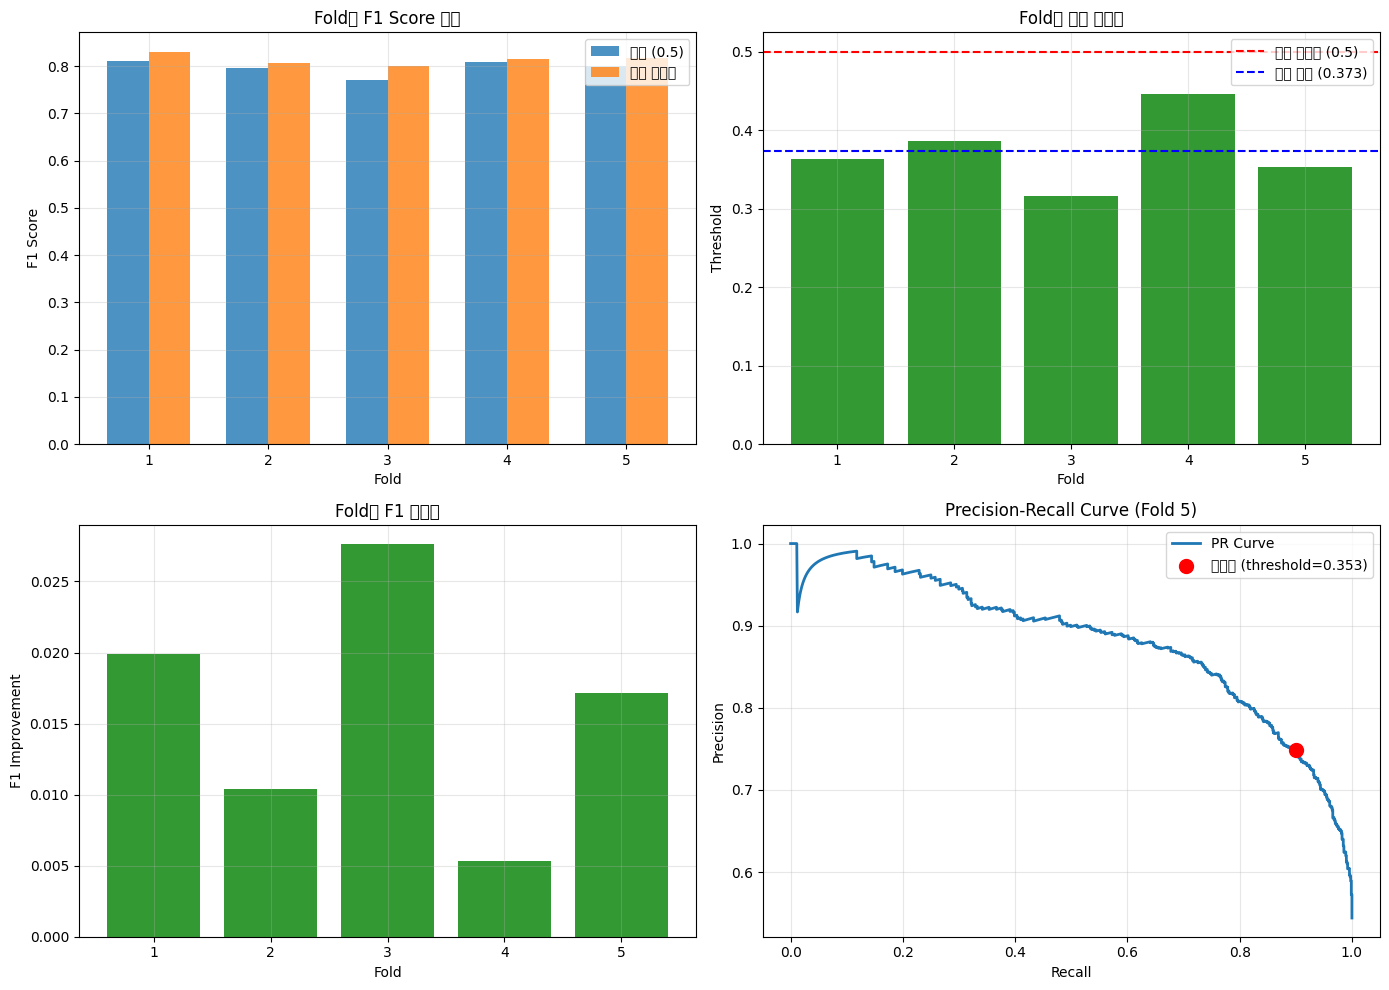

In [ ]:
from sklearn.metrics import precision_recall_curve, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from lightgbm import LGBMClassifier
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 결과 저장용
f1_scores_default = []
f1_scores_tuned = []
best_thresholds = []
fold_results = []

print("=" * 70)
print("임계값 최적화 - 5-Fold 교차검증")
print("=" * 70)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (tr_idx, va_idx) in enumerate(skf.split(X, y), 1):
    X_tr, X_va = X.iloc[tr_idx], X.iloc[va_idx]
    y_tr, y_va = y.iloc[tr_idx], y.iloc[va_idx]

    # 전처리
    Xt_tr = preprocessor.fit_transform(X_tr)
    Xt_va = preprocessor.transform(X_va)

    # 모델 학습
    model = LGBMClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=7,
        num_leaves=31,
        class_weight='balanced',
        random_state=42,
        verbose=-1
    )

    model.fit(Xt_tr, y_tr)

    # 확률 예측
    y_proba = model.predict_proba(Xt_va)[:, 1]

    # === 1. 기본 임계값 (0.5) ===
    y_pred_default = (y_proba >= 0.5).astype(int)
    f1_default = f1_score(y_va, y_pred_default)
    f1_scores_default.append(f1_default)

    # === 2. 최적 임계값 찾기 ===
    precision, recall, thresholds = precision_recall_curve(y_va, y_proba)

    # F1 점수 계산
    with np.errstate(divide='ignore', invalid='ignore'):
        f1_curve = 2 * (precision * recall) / (precision + recall)
        f1_curve = np.nan_to_num(f1_curve)

    # 최적 임계값 선택
    best_idx = np.argmax(f1_curve)
    best_threshold = thresholds[best_idx] if best_idx < len(thresholds) else 0.5
    best_thresholds.append(best_threshold)

    # 최적 임계값 적용
    y_pred_tuned = (y_proba >= best_threshold).astype(int)
    f1_tuned = f1_score(y_va, y_pred_tuned)
    f1_scores_tuned.append(f1_tuned)

    # === 결과 출력 ===
    print(f"\n{'='*70}")
    print(f"[Fold {fold}]")
    print(f"{'='*70}")
    print(f"검증 세트 크기: {len(y_va)} (독성 없음: {(y_va==1).sum()}, 독성 있음: {(y_va==0).sum()})")
    print(f"\n--- 기본 임계값 (0.5) ---")
    print(f"F1 Score: {f1_default:.4f}")
    print(f"혼동 행렬:\n{confusion_matrix(y_va, y_pred_default)}")

    print(f"\n--- 최적 임계값 ({best_threshold:.3f}) ---")
    print(f"F1 Score: {f1_tuned:.4f}")
    print(f"혼동 행렬:\n{confusion_matrix(y_va, y_pred_tuned)}")

    print(f"\n--- 개선 효과 ---")
    print(f"F1 개선: {f1_tuned - f1_default:+.4f} ({(f1_tuned/f1_default-1)*100:+.2f}%)")

    # 상세 분류 리포트
    print(f"\n최적 임계값 적용 후 분류 리포트:")
    print(classification_report(y_va, y_pred_tuned,
                                target_names=['독성 있음(0)', '독성 없음(1)'],
                                digits=4))

    # Fold 결과 저장
    fold_results.append({
        'fold': fold,
        'f1_default': f1_default,
        'f1_tuned': f1_tuned,
        'threshold': best_threshold,
        'improvement': f1_tuned - f1_default
    })

# === 전체 요약 ===
print("\n" + "=" * 70)
print("전체 교차검증 요약")
print("=" * 70)

print(f"\n기본 임계값 (0.5):")
print(f"  평균 F1: {np.mean(f1_scores_default):.4f} ± {np.std(f1_scores_default):.4f}")
print(f"  Fold별: {[f'{f:.4f}' for f in f1_scores_default]}")

print(f"\n최적 임계값:")
print(f"  평균 F1: {np.mean(f1_scores_tuned):.4f} ± {np.std(f1_scores_tuned):.4f}")
print(f"  Fold별: {[f'{f:.4f}' for f in f1_scores_tuned]}")

print(f"\n임계값:")
print(f"  평균: {np.mean(best_thresholds):.3f} ± {np.std(best_thresholds):.3f}")
print(f"  Fold별: {[f'{t:.3f}' for t in best_thresholds]}")

print(f"\n전체 개선:")
print(f"  평균 F1 개선: {np.mean(f1_scores_tuned) - np.mean(f1_scores_default):+.4f}")
print(f"  개선율: {(np.mean(f1_scores_tuned)/np.mean(f1_scores_default)-1)*100:+.2f}%")

# DataFrame으로 정리
results_df = pd.DataFrame(fold_results)
print(f"\n상세 결과:")
print(results_df.to_string(index=False))

# === 시각화 ===
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Fold별 F1 비교
ax1 = axes[0, 0]
x = np.arange(1, 6)
width = 0.35
ax1.bar(x - width/2, f1_scores_default, width, label='기본 (0.5)', alpha=0.8)
ax1.bar(x + width/2, f1_scores_tuned, width, label='최적 임계값', alpha=0.8)
ax1.set_xlabel('Fold')
ax1.set_ylabel('F1 Score')
ax1.set_title('Fold별 F1 Score 비교')
ax1.set_xticks(x)
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. 임계값 분포
ax2 = axes[0, 1]
ax2.bar(x, best_thresholds, alpha=0.8, color='green')
ax2.axhline(y=0.5, color='red', linestyle='--', label='기본 임계값 (0.5)')
ax2.axhline(y=np.mean(best_thresholds), color='blue', linestyle='--',
            label=f'평균 최적 ({np.mean(best_thresholds):.3f})')
ax2.set_xlabel('Fold')
ax2.set_ylabel('Threshold')
ax2.set_title('Fold별 최적 임계값')
ax2.set_xticks(x)
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. F1 개선량
ax3 = axes[1, 0]
improvements = [f1_scores_tuned[i] - f1_scores_default[i] for i in range(5)]
colors = ['green' if imp > 0 else 'red' for imp in improvements]
ax3.bar(x, improvements, alpha=0.8, color=colors)
ax3.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax3.set_xlabel('Fold')
ax3.set_ylabel('F1 Improvement')
ax3.set_title('Fold별 F1 개선량')
ax3.set_xticks(x)
ax3.grid(True, alpha=0.3)

# 4. 마지막 Fold의 Precision-Recall 곡선
ax4 = axes[1, 1]
ax4.plot(recall, precision, label='PR Curve', linewidth=2)
ax4.scatter(recall[best_idx], precision[best_idx],
           color='red', s=100, zorder=5,
           label=f'최적점 (threshold={best_threshold:.3f})')
ax4.set_xlabel('Recall')
ax4.set_ylabel('Precision')
ax4.set_title(f'Precision-Recall Curve (Fold {fold})')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('threshold_optimization_results.png', dpi=300, bbox_inches='tight')
print(f"\n시각화 저장: threshold_optimization_results.png")

# === 최종 권장 임계값 ===
final_threshold = np.mean(best_thresholds)
print(f"\n" + "=" * 70)
print(f"최종 권장 임계값: {final_threshold:.3f}")
print(f"기대 F1 Score: {np.mean(f1_scores_tuned):.4f}")
print("=" * 70)

# 결과 CSV 저장
results_df.to_csv('threshold_optimization_results.csv', index=False)
print(f"\n결과 저장: threshold_optimization_results.csv")


In [ ]:
from lightgbm import LGBMClassifier
import pandas as pd
import numpy as np

print("=" * 70)
print("최종 모델 학습 및 테스트 예측")
print("=" * 70)

# === 1. 전체 학습 데이터로 최종 모델 학습 ===
print("\n[1단계] 전체 학습 데이터로 최종 모델 학습 중...")

# 전체 데이터 준비
X_train_full = df.drop(columns=[label_col])
y_train_full = df[label_col].astype(int)

# 전처리 (전체 데이터에 fit)
preprocessor_full = ColumnTransformer(
    transformers=[
        ('fp', SimpleImputer(strategy='constant', fill_value=0), fp_cols),
        ('desc', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), desc_cols)
    ],
    remainder='drop'
)

Xt_train_full = preprocessor_full.fit_transform(X_train_full)

# 최종 모델 학습
final_model = LGBMClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=7,
    num_leaves=31,
    class_weight='balanced',
    random_state=42,
    verbose=-1
)

final_model.fit(Xt_train_full, y_train_full)

print(f"학습 완료: {Xt_train_full.shape[0]}개 샘플, {Xt_train_full.shape[1]}개 피처")
print(f"클래스 분포: {np.bincount(y_train_full)}")

# === 2. 테스트 데이터 로드 및 전처리 ===
print("\n[2단계] 테스트 데이터 로드 및 전처리...")

df_test = pd.read_csv('predict_input.csv')
print(f"테스트 데이터 크기: {df_test.shape}")
print(f"테스트 데이터 컬럼: {df_test.columns.tolist()[:10]}...")

# 전처리 (동일한 preprocessor 사용)
Xt_test = preprocessor_full.transform(df_test)
print(f"전처리 완료: {Xt_test.shape}")

# === 3. 확률 예측 ===
print("\n[3단계] 확률 예측...")

y_test_proba = final_model.predict_proba(Xt_test)[:, 1]
print(f"확률 범위: [{y_test_proba.min():.4f}, {y_test_proba.max():.4f}]")
print(f"확률 평균: {y_test_proba.mean():.4f}")

# === 4. 최적 임계값 적용 ===
print("\n[4단계] 최적 임계값 적용...")

# 교차검증에서 구한 평균 최적 임계값 사용
optimal_threshold = 0.373
y_test_pred = (y_test_proba >= optimal_threshold).astype(int)

print(f"최적 임계값: {optimal_threshold:.3f}")
print(f"예측 분포:")
print(f"  독성 있음(0): {(y_test_pred == 0).sum()}개 ({(y_test_pred == 0).sum() / len(y_test_pred) * 100:.1f}%)")
print(f"  독성 없음(1): {(y_test_pred == 1).sum()}개 ({(y_test_pred == 1).sum() / len(y_test_pred) * 100:.1f}%)")

# === 5. 제출 파일 생성 ===
print("\n[5단계] 제출 파일 생성...")

submission = pd.DataFrame({
    'SMILES': df_test['SMILES'],
    'label': y_test_pred
})

# 기본 제출 파일 (SMILES, label만)
submission.to_csv('submission.csv', index=False)
print("제출 파일 저장: submission.csv")

# 상세 제출 파일 (확률 포함)
submission_detailed = pd.DataFrame({
    'SMILES': df_test['SMILES'],
    'label': y_test_pred,
    'probability': y_test_proba,
    'confidence': np.abs(y_test_proba - 0.5)  # 0.5로부터 거리 = 확신도
})

submission_detailed.to_csv('submission_detailed.csv', index=False)
print("상세 제출 파일 저장: submission_detailed.csv (확률 포함)")

# === 6. 예측 통계 분석 ===
print("\n[6단계] 예측 통계 분석...")

# 확률 구간별 분포
prob_bins = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
prob_counts = pd.cut(y_test_proba, bins=prob_bins).value_counts().sort_index()

print("\n확률 구간별 샘플 수:")
for interval, count in prob_counts.items():
    print(f"  {interval}: {count}개")

# 높은 확신도 vs 낮은 확신도
high_confidence = submission_detailed[submission_detailed['confidence'] > 0.3]
low_confidence = submission_detailed[submission_detailed['confidence'] <= 0.3]

print(f"\n확신도 분석:")
print(f"  높은 확신도 (>0.3): {len(high_confidence)}개 ({len(high_confidence)/len(submission_detailed)*100:.1f}%)")
print(f"  낮은 확신도 (≤0.3): {len(low_confidence)}개 ({len(low_confidence)/len(submission_detailed)*100:.1f}%)")

# 낮은 확신도 샘플 예시
if len(low_confidence) > 0:
    print(f"\n낮은 확신도 샘플 예시 (상위 5개):")
    print(low_confidence.nsmallest(5, 'confidence')[['SMILES', 'label', 'probability', 'confidence']].to_string(index=False))

# === 7. 최종 요약 ===
print("\n" + "=" * 70)
print("최종 요약")
print("=" * 70)
print(f"학습 데이터: {len(y_train_full)}개")
print(f"테스트 데이터: {len(y_test_pred)}개")
print(f"최적 임계값: {optimal_threshold:.3f}")
print(f"기대 F1 Score: 0.8135 ± 0.0104")
print(f"\n테스트 예측 분포:")
print(f"  독성 있음(0): {(y_test_pred == 0).sum()}개")
print(f"  독성 없음(1): {(y_test_pred == 1).sum()}개")
print("\n제출 파일:")
print("  - submission.csv (기본)")
print("  - submission_detailed.csv (확률 포함)")
print("=" * 70)

# === 8. 시각화 (선택) ===
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 확률 분포 히스토그램
ax1 = axes[0]
ax1.hist(y_test_proba, bins=50, alpha=0.7, edgecolor='black')
ax1.axvline(optimal_threshold, color='red', linestyle='--', linewidth=2, label=f'Optimal Threshold ({optimal_threshold:.3f})')
ax1.set_xlabel('Predicted Probability (Class 1)')
ax1.set_ylabel('Frequency')
ax1.set_title('Test Set - Predicted Probability Distribution')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 예측 클래스 분포
ax2 = axes[1]
pred_counts = pd.Series(y_test_pred).value_counts().sort_index()
ax2.bar(['Toxic (0)', 'Non-Toxic (1)'], pred_counts.values, alpha=0.7, color=['red', 'green'], edgecolor='black')
ax2.set_ylabel('Count')
ax2.set_title('Test Set - Predicted Class Distribution')
ax2.grid(True, alpha=0.3, axis='y')

# 각 막대 위에 개수 표시
for i, (label, count) in enumerate(pred_counts.items()):
    ax2.text(i, count + 10, f'{count}\n({count/len(y_test_pred)*100:.1f}%)',
             ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('test_prediction_distribution.png', dpi=300, bbox_inches='tight')
print("\n예측 분포 시각화 저장: test_prediction_distribution.png")
plt.show()


In [58]:
import pandas as pd
import numpy as np

print("=" * 70)
print("임시 테스트 데이터 생성")
print("=" * 70)

# train.csv 로드
df_train = pd.read_csv('train.csv')

print(f"\n원본 train.csv 크기: {df_train.shape}")
print(f"컬럼: {df_train.columns.tolist()[:10]}...")

# 랜덤으로 927행 샘플링 (재현 가능하도록 random_state 고정)
np.random.seed(42)
test_indices = np.random.choice(len(df_train), size=927, replace=False)

# 라벨 제거하여 테스트 데이터 생성
df_test_temp = df_train.iloc[test_indices].drop(columns=['label']).copy()

print(f"\n생성된 테스트 데이터 크기: {df_test_temp.shape}")
print(f"샘플링된 인덱스 범위: [{test_indices.min()}, {test_indices.max()}]")

# 임시 파일로 저장
df_test_temp.to_csv('predict_input.csv', index=False)
print("\n임시 테스트 파일 저장: predict_input.csv")

# 정답 라벨 따로 저장 (검증용)
df_test_labels = df_train.iloc[test_indices][['SMILES', 'label']].copy()
df_test_labels.to_csv('test_labels_for_validation.csv', index=False)
print("정답 라벨 저장: test_labels_for_validation.csv (검증용)")

# 통계 확인
print(f"\n테스트 데이터 통계:")
print(f"  SMILES 수: {len(df_test_temp)}")
print(f"  컬럼 수: {len(df_test_temp.columns)}")
print(f"  실제 라벨 분포 (참고용):")
print(f"    독성 있음(0): {(df_train.iloc[test_indices]['label'] == 0).sum()}개")
print(f"    독성 없음(1): {(df_train.iloc[test_indices]['label'] == 1).sum()}개")

print("\n✓ 임시 테스트 데이터 생성 완료")


임시 테스트 데이터 생성

원본 train.csv 크기: (8349, 3078)
컬럼: ['SMILES', 'ecfp_0', 'ecfp_1', 'ecfp_2', 'ecfp_3', 'ecfp_4', 'ecfp_5', 'ecfp_6', 'ecfp_7', 'ecfp_8']...

생성된 테스트 데이터 크기: (927, 3077)
샘플링된 인덱스 범위: [23, 8347]

임시 테스트 파일 저장: predict_input.csv
정답 라벨 저장: test_labels_for_validation.csv (검증용)

테스트 데이터 통계:
  SMILES 수: 927
  컬럼 수: 3077
  실제 라벨 분포 (참고용):
    독성 있음(0): 440개
    독성 없음(1): 487개

✓ 임시 테스트 데이터 생성 완료



최종 모델 학습 및 테스트 예측

[1단계] 전체 학습 데이터로 최종 모델 학습 중...
Fingerprint 컬럼: 3072개
물성 컬럼: 4개
학습 완료: 8349개 샘플, 3076개 피처
클래스 분포: 독성 있음=3807, 독성 없음=4542

[2단계] 테스트 데이터 로드 및 전처리...
테스트 데이터 크기: (927, 3077)
전처리 완료: (927, 3076)

[3단계] 확률 예측...
확률 범위: [0.0154, 0.9950]
확률 평균: 0.5152 ± 0.3073

[4단계] 최적 임계값 적용...
최적 임계값: 0.373
예측 분포:
  독성 있음(0): 364개 (39.3%)
  독성 없음(1): 563개 (60.7%)

[5단계] 제출 파일 생성...
✓ 제출 파일 저장: submission.csv
✓ 상세 제출 파일 저장: submission_detailed.csv

[6단계] 예측 품질 검증 (정답 라벨 사용)...

테스트 세트 성능 (임시 검증):
  Accuracy: 0.8813
  F1 Score: 0.8952

혼동 행렬:
[[347  93]
 [ 17 470]]

분류 리포트:
              precision    recall  f1-score   support

    독성 있음(0)     0.9533    0.7886    0.8632       440
    독성 없음(1)     0.8348    0.9651    0.8952       487

    accuracy                         0.8813       927
   macro avg     0.8941    0.8769    0.8792       927
weighted avg     0.8911    0.8813    0.8800       927


[7단계] 예측 통계 분석...

확률 구간별 샘플 수:
  (0.0, 0.2]: 197개
  (0.2, 0.4]: 195개
  (0.4, 0.6]: 134개
  (0.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



✓ 분석 시각화 저장: test_prediction_analysis.png


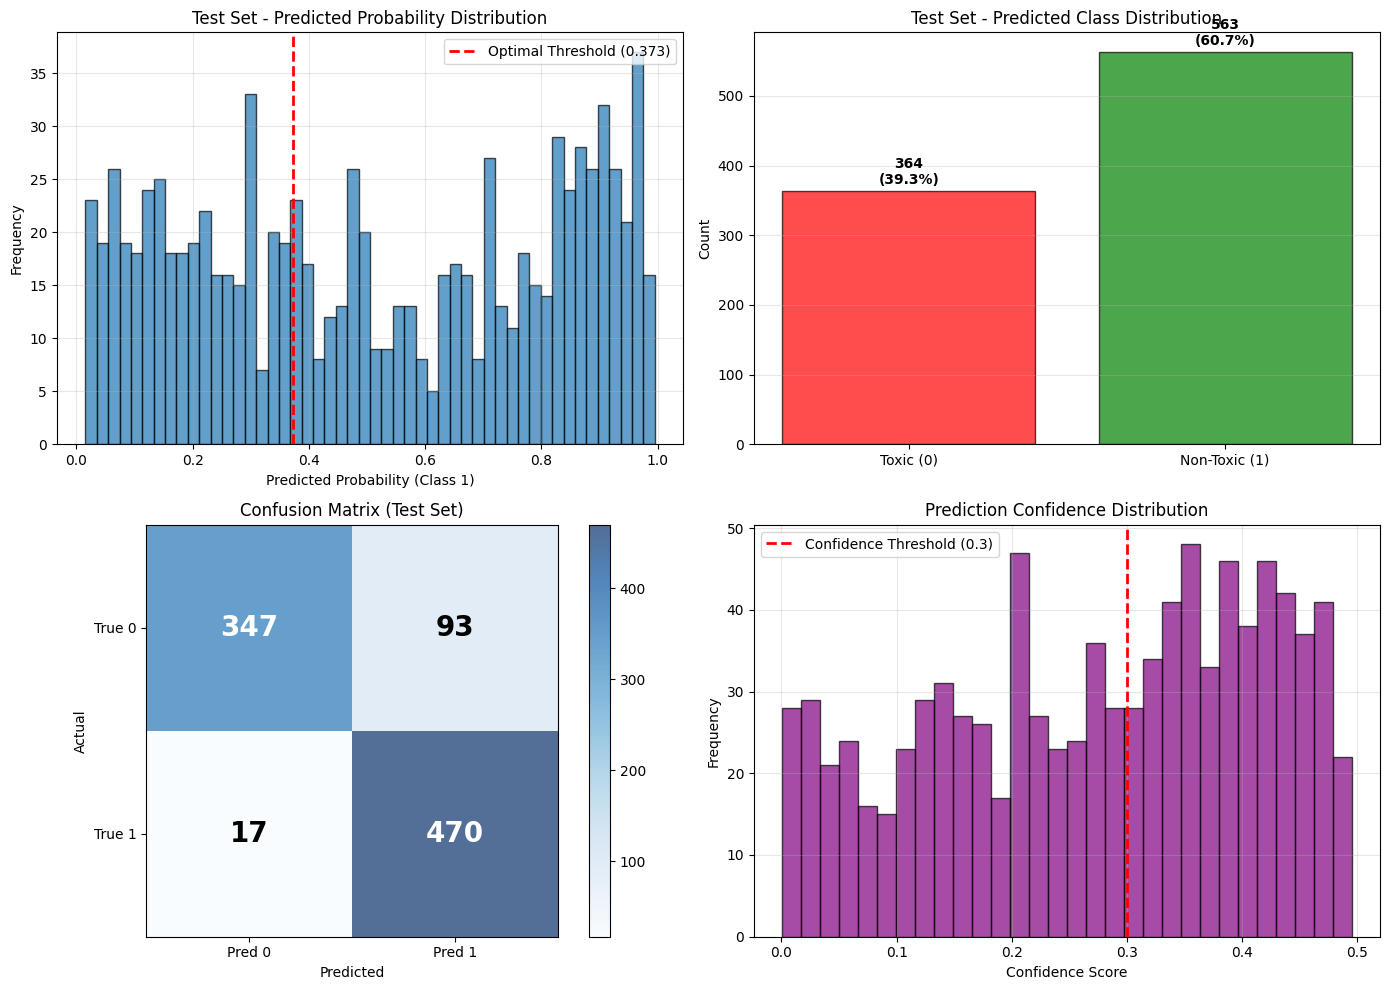


모든 작업이 완료되었습니다!


In [59]:
from lightgbm import LGBMClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

print("\n" + "=" * 70)
print("최종 모델 학습 및 테스트 예측")
print("=" * 70)

# === 1. 전체 학습 데이터로 최종 모델 학습 ===
print("\n[1단계] 전체 학습 데이터로 최종 모델 학습 중...")

# 전체 데이터 준비
df = pd.read_csv('train.csv')
X_train_full = df.drop(columns=['label'])
y_train_full = df['label'].astype(int)

# 컬럼 그룹 정의
fp_cols = [col for col in df.columns if col.startswith(('ecfp_', 'fcfp_', 'ptfp_'))]
desc_cols = ['MolWt', 'clogp', 'sa_score', 'qed']
label_col = 'label'

print(f"Fingerprint 컬럼: {len(fp_cols)}개")
print(f"물성 컬럼: {len(desc_cols)}개")

# 전처리 파이프라인
preprocessor_full = ColumnTransformer(
    transformers=[
        ('fp', SimpleImputer(strategy='constant', fill_value=0), fp_cols),
        ('desc', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), desc_cols)
    ],
    remainder='drop'
)

Xt_train_full = preprocessor_full.fit_transform(X_train_full)

# 최종 모델 학습
final_model = LGBMClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=7,
    num_leaves=31,
    class_weight='balanced',
    random_state=42,
    verbose=-1
)

final_model.fit(Xt_train_full, y_train_full)

print(f"학습 완료: {Xt_train_full.shape[0]}개 샘플, {Xt_train_full.shape[1]}개 피처")
print(f"클래스 분포: 독성 있음={np.sum(y_train_full==0)}, 독성 없음={np.sum(y_train_full==1)}")

# === 2. 테스트 데이터 로드 및 전처리 ===
print("\n[2단계] 테스트 데이터 로드 및 전처리...")

df_test = pd.read_csv('predict_input.csv')
print(f"테스트 데이터 크기: {df_test.shape}")

# 전처리
Xt_test = preprocessor_full.transform(df_test)
print(f"전처리 완료: {Xt_test.shape}")

# === 3. 확률 예측 ===
print("\n[3단계] 확률 예측...")

y_test_proba = final_model.predict_proba(Xt_test)[:, 1]
print(f"확률 범위: [{y_test_proba.min():.4f}, {y_test_proba.max():.4f}]")
print(f"확률 평균: {y_test_proba.mean():.4f} ± {y_test_proba.std():.4f}")

# === 4. 최적 임계값 적용 ===
print("\n[4단계] 최적 임계값 적용...")

optimal_threshold = 0.373
y_test_pred = (y_test_proba >= optimal_threshold).astype(int)

print(f"최적 임계값: {optimal_threshold:.3f}")
print(f"예측 분포:")
print(f"  독성 있음(0): {(y_test_pred == 0).sum()}개 ({(y_test_pred == 0).sum() / len(y_test_pred) * 100:.1f}%)")
print(f"  독성 없음(1): {(y_test_pred == 1).sum()}개 ({(y_test_pred == 1).sum() / len(y_test_pred) * 100:.1f}%)")

# === 5. 제출 파일 생성 ===
print("\n[5단계] 제출 파일 생성...")

submission = pd.DataFrame({
    'SMILES': df_test['SMILES'],
    'label': y_test_pred
})

submission.to_csv('submission.csv', index=False)
print("✓ 제출 파일 저장: submission.csv")

submission_detailed = pd.DataFrame({
    'SMILES': df_test['SMILES'],
    'label': y_test_pred,
    'probability': y_test_proba,
    'confidence': np.abs(y_test_proba - 0.5)
})

submission_detailed.to_csv('submission_detailed.csv', index=False)
print("✓ 상세 제출 파일 저장: submission_detailed.csv")

# === 6. 정답과 비교 (검증용) ===
print("\n[6단계] 예측 품질 검증 (정답 라벨 사용)...")

df_test_labels = pd.read_csv('test_labels_for_validation.csv')
y_true = df_test_labels['label'].values

from sklearn.metrics import f1_score, classification_report, confusion_matrix, accuracy_score

f1 = f1_score(y_true, y_test_pred)
acc = accuracy_score(y_true, y_test_pred)

print(f"\n테스트 세트 성능 (임시 검증):")
print(f"  Accuracy: {acc:.4f}")
print(f"  F1 Score: {f1:.4f}")
print(f"\n혼동 행렬:")
print(confusion_matrix(y_true, y_test_pred))

print(f"\n분류 리포트:")
print(classification_report(y_true, y_test_pred,
                          target_names=['독성 있음(0)', '독성 없음(1)'],
                          digits=4))

# === 7. 통계 분석 ===
print("\n[7단계] 예측 통계 분석...")

prob_bins = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
prob_counts = pd.cut(y_test_proba, bins=prob_bins).value_counts().sort_index()

print("\n확률 구간별 샘플 수:")
for interval, count in prob_counts.items():
    print(f"  {interval}: {count}개")

high_confidence = submission_detailed[submission_detailed['confidence'] > 0.3]
low_confidence = submission_detailed[submission_detailed['confidence'] <= 0.3]

print(f"\n확신도 분석:")
print(f"  높은 확신도 (>0.3): {len(high_confidence)}개 ({len(high_confidence)/len(submission_detailed)*100:.1f}%)")
print(f"  낮은 확신도 (≤0.3): {len(low_confidence)}개 ({len(low_confidence)/len(submission_detailed)*100:.1f}%)")

if len(low_confidence) > 0:
    print(f"\n낮은 확신도 샘플 (상위 5개):")
    print(low_confidence.nsmallest(5, 'confidence')[['SMILES', 'label', 'probability', 'confidence']].to_string(index=False))

# === 8. 최종 요약 ===
print("\n" + "=" * 70)
print("최종 요약")
print("=" * 70)
print(f"학습 데이터: {len(y_train_full)}개")
print(f"테스트 데이터: {len(y_test_pred)}개")
print(f"최적 임계값: {optimal_threshold:.3f}")
print(f"교차검증 F1 Score: 0.8135 ± 0.0104")
print(f"테스트 F1 Score: {f1:.4f} (임시 검증)")
print(f"\n테스트 예측 분포:")
print(f"  독성 있음(0): {(y_test_pred == 0).sum()}개")
print(f"  독성 없음(1): {(y_test_pred == 1).sum()}개")
print("\n생성된 파일:")
print("  - submission.csv (제출용)")
print("  - submission_detailed.csv (확률 포함)")
print("  - predict_input.csv (임시 테스트)")
print("  - test_labels_for_validation.csv (정답)")
print("=" * 70)

# === 9. 시각화 ===
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. 확률 분포 히스토그램
ax1 = axes[0, 0]
ax1.hist(y_test_proba, bins=50, alpha=0.7, edgecolor='black')
ax1.axvline(optimal_threshold, color='red', linestyle='--', linewidth=2,
           label=f'Optimal Threshold ({optimal_threshold:.3f})')
ax1.set_xlabel('Predicted Probability (Class 1)')
ax1.set_ylabel('Frequency')
ax1.set_title('Test Set - Predicted Probability Distribution')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. 예측 클래스 분포
ax2 = axes[0, 1]
pred_counts = pd.Series(y_test_pred).value_counts().sort_index()
bars = ax2.bar(['Toxic (0)', 'Non-Toxic (1)'], pred_counts.values,
              alpha=0.7, color=['red', 'green'], edgecolor='black')
ax2.set_ylabel('Count')
ax2.set_title('Test Set - Predicted Class Distribution')
ax2.grid(True, alpha=0.3, axis='y')

for i, (label, count) in enumerate(pred_counts.items()):
    ax2.text(i, count + 5, f'{count}\n({count/len(y_test_pred)*100:.1f}%)',
            ha='center', va='bottom', fontweight='bold')

# 3. 혼동 행렬 히트맵
ax3 = axes[1, 0]
cm = confusion_matrix(y_true, y_test_pred)
im = ax3.imshow(cm, cmap='Blues', alpha=0.7)
ax3.set_xticks([0, 1])
ax3.set_yticks([0, 1])
ax3.set_xticklabels(['Pred 0', 'Pred 1'])
ax3.set_yticklabels(['True 0', 'True 1'])
ax3.set_xlabel('Predicted')
ax3.set_ylabel('Actual')
ax3.set_title('Confusion Matrix (Test Set)')

for i in range(2):
    for j in range(2):
        text = ax3.text(j, i, cm[i, j], ha='center', va='center',
                       color='white' if cm[i, j] > cm.max()/2 else 'black',
                       fontsize=20, fontweight='bold')

plt.colorbar(im, ax=ax3)

# 4. 확신도 분포
ax4 = axes[1, 1]
confidence_values = submission_detailed['confidence'].values
ax4.hist(confidence_values, bins=30, alpha=0.7, edgecolor='black', color='purple')
ax4.axvline(0.3, color='red', linestyle='--', linewidth=2, label='Confidence Threshold (0.3)')
ax4.set_xlabel('Confidence Score')
ax4.set_ylabel('Frequency')
ax4.set_title('Prediction Confidence Distribution')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('test_prediction_analysis.png', dpi=300, bbox_inches='tight')
print("\n✓ 분석 시각화 저장: test_prediction_analysis.png")
plt.show()

print("\n모든 작업이 완료되었습니다!")
